# Clustering algorithms comparison

A clustering algorithm is an unsupervised learning algorithm that groups similar instances together. In this notebook we will compare the performance of different clustering algorithms on a dataset, obtaining what is the best algorithm and its optimal hyperparameters for this dataset.

## Index
1. [Imports](#id1)
2. [File reading](#id2)
3. [Clustering algorithms](#id3)
    1. [BIRCH](#id3.1)
    2. [DBSCAN](#id3.2)
    3. [K-means](#id3.3)
    4. [Mini-Batch K-means](#id3.4)
    5. [Mean Shift](#id3.5)
    6. [OPTICS](#id3.6)
    7. [Spectral Clustering](#id3.7)
    8. [Mixture of Gaussians](#id3.8)
    9. [Partition around medoids (PAM)](#id3.9)
    10. [UPGMA](#id3.10) 
4. [Quality metrics](#id4)
5. [Clustering method](#id5)
6. [Quality metrics method](#id6)
7. [Visualizing a labelled dataset](#id7)
8. [Testing methods](#id8)
9. [Optimal algorithm hyperparameters.](#id9)

### 1. Imports <div id='id1'></div>

In the following cell we import the necessary libraries for this notebook.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import Birch, DBSCAN, KMeans, MiniBatchKMeans, OPTICS, MeanShift, SpectralClustering
from sklearn.cluster import estimate_bandwidth
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

from sklearn.metrics import pairwise_distances, silhouette_score, calinski_harabasz_score, davies_bouldin_score

### 2. File reading <div id='id2'></div>

In this section we read the dataset from a file and we store it in a variable. We also show the first 5 rows of the dataset and we visualize the data using a 3D plot.

          0         1         2
0  0.912742  1.719443  1.606405
1  0.313207  1.769782  1.628300
2  1.423678 -0.713694 -0.594431
3 -0.066379  2.153243  1.963148
4  1.036332  0.658611  0.642875


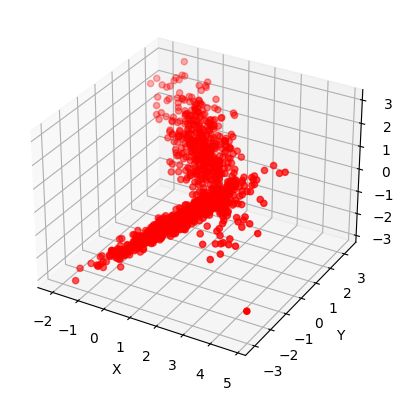

In [2]:
# read txt file
file = pd.read_csv('alvbercau_alvgonfri_dataset.txt', sep=" ", header=None)

# convert to dataframe in order to use pandas methods if needed
df = pd.DataFrame(file)

# show the first 5 rows
print(df.head())

# visualize the data with a 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0], df[1], df[2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# convert dataframe to numpy array
X = df.values

### 3. Clustering algorithms <div id='id3'></div>

In this section we are defining the different clustering algorithms that we are going to use. We are using the scikit-learn library to implement the first eight algorithms. The last two algorithms, Partition around medoids (PAM) and UPGMA, are implemented by us.

#### BIRCH <div id='id31'></div>

In [3]:
def birch(data, k):
    brc = Birch(n_clusters=k).fit(data)
    labels = brc.predict(data)
    return labels

#### DBSCAN <div id='id32'></div>

In [90]:
def dbscan(data, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    return labels

#### K-Means <div id='id33'></div>

In [5]:
def kmeans(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
    labels = kmeans.predict(data)
    return labels

#### Mini-Batch K-Means <div id='id34'></div>

In [6]:
#Se usa para reducir el tiempo de calculo (Se suele reducir la calidad de los resultados)
def mini_batch_kmeans(data, k):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=6, max_iter=10,n_init=10).fit(data)
    labels = kmeans.predict(data)
    return labels

#### Mean Shift <div id='id35'></div>

In [7]:
# parameters quantile and n_samples are used to estimate the bandwidth, which is the hyperparameter of Mean Shift
def mean_shift(data, quantile, n_samples):
    bandwidth = estimate_bandwidth(data, quantile=quantile, n_samples=n_samples)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(data)
    labels = ms.labels_
    return labels

#### OPTICS <div id='id36'></div>

In [8]:
def optics(data, eps, min_samples):
    db = OPTICS(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    return labels

#### Spectral Clustering <div id='id37'></div>

In [9]:
def spectral_clustering(data, k):
    sc = SpectralClustering(n_clusters=k, assign_labels="discretize", random_state=0).fit(data)
    labels = sc.labels_
    return labels

#### Mixture of Gaussians <div id='id38'></div>

In [10]:
def gaussian_mixture(data, k):
    gmm = GaussianMixture(n_components=k).fit(data)
    labels = gmm.predict(data)
    return labels

#### Partition around medoids (PAM) <div id= 'id39'></div>

In [11]:
def pam(X, n_clusters, max_iterations=100):
    # Initialize medoids randomly
    medoids = np.random.choice(range(X.shape[0]), size=n_clusters, replace=False)
    current_medoids = np.copy(medoids)

    for _ in range(max_iterations):
        # Assign each data point to the nearest medoid
        labels = assign_points_to_medoids(X, current_medoids)

        # Update the medoids by computing the total distance within each cluster
        for cluster_id in range(n_clusters):
            cluster_points = X[labels == cluster_id]
            medoid_id = np.argmin(np.sum(cdist(cluster_points, cluster_points, metric='cityblock'), axis=1))
            current_medoids[cluster_id] = np.where(labels == cluster_id)[0][medoid_id] 

        # If the medoids have not changed, terminate the algorithm
        if np.array_equal(medoids, current_medoids):
            break

        medoids = np.copy(current_medoids)

    return labels


def assign_points_to_medoids(X, medoids):
    distance_matrix = np.zeros((X.shape[0], len(medoids)))
    for i, medoid in enumerate(medoids):
        distance_matrix[:, i] = np.sum(np.abs(X - X[medoid]), axis=1)
    return np.argmin(distance_matrix, axis=1)

#### UPGMA <div id='id310'></div>

In [12]:
def upgma(data, num_clusters, max_iterations=100):
    # Step 1: Create a distance matrix
    distance_matrix = pairwise_distances(data, metric='euclidean')
    np.fill_diagonal(distance_matrix, np.inf)  # Fill diagonal with infinity

    # Step 2: Create a dictionary to store the cluster labels and distances
    clusters = {i: [i] for i in range(data.shape[0])}
    distances = {i: 0 for i in range(data.shape[0])}

    # Step 3: Perform clustering
    for iteration in range(max_iterations):
        # Find the minimum distance in the distance matrix
        min_distance = np.min(distance_matrix)
        if min_distance == np.inf:
            break  # Terminate the loop if the minimum distance is infinity

        # Find the indices of the two clusters with the minimum distance
        cluster_indices = np.where(distance_matrix == min_distance)
        cluster1, cluster2 = cluster_indices[0][0], cluster_indices[1][0]

        # Merge the two clusters
        new_cluster = clusters[cluster1] + clusters[cluster2]
        clusters[data.shape[0] + iteration] = new_cluster

        # Update the distance matrix
        for cluster in clusters:
            if cluster != cluster1 and cluster != cluster2:
                avg_distance = (distances[cluster1] * len(clusters[cluster1]) +
                                distances[cluster2] * len(clusters[cluster2])) / (len(clusters[cluster1]) +
                                                                                 len(clusters[cluster2]))
                distances[cluster] = avg_distance

        # Set the merged clusters' distances to infinity in the distance matrix
        distance_matrix[cluster1, :] = np.inf
        distance_matrix[cluster2, :] = np.inf
        distance_matrix[:, cluster1] = np.inf
        distance_matrix[:, cluster2] = np.inf

    # Step 4: Assign cluster labels to the original data points
    labels = np.zeros(data.shape[0], dtype=int)
    for cluster_id, cluster in enumerate(clusters.values()):
        if cluster_id < num_clusters:
            for sample_id in cluster:
                labels[sample_id] = cluster_id
        else:
            for sample_id in cluster:
                labels[sample_id] = 0

    # Step 5: Create a Pandas DataFrame for the clusters
    result = pd.DataFrame(data=data, columns=['x', 'y', 'z'])
    result['Cluster'] = labels

    return result['Cluster'].values


In [13]:
def UPGMA(data, k):
   # Calcula las distancias utilizando la métrica euclidiana
    distances = pdist(data, metric='euclidean')

    # Calcula la matriz de enlace utilizando UPGMA
    Z = linkage(distances, method='average')

    # Realiza la asignación de clústeres utilizando la función fcluster
    labels = fcluster(Z, k, criterion='maxclust')

    return labels

### 4. Quality metrics <div id='id4'></div>

We will use three different metrics to evaluate the quality of the clustering algorithms. These metrics are the following:

- Silhouette coefficient
- Calinski-Harabasz index
- Davies-Bouldin index

There is no need to implement these metrics, since they are already implemented in the `sklearn` library, and we will use them directly in the quality metrics method defined in the sixth section of this notebook.

### 5. Clustering method <div id='id5'></div>

In the following cell we define the "clustering method", which will be used to apply a clustering algorithm to the dataset. This method receives as parameters the dataset, the algorithm to use, and the algorithm hyperparameters as a dictionary. It returns the labels assigned to each instance of the dataset by the specified algorithm, or an warning message if the algorithm is not recognized.

In [14]:
def clustering(data, algorithm, hyperparameters):
    if algorithm == 'birch':
        return birch(data, hyperparameters.get('k'))
    elif algorithm == 'dbscan':
        return dbscan(data,  hyperparameters.get('eps'),  hyperparameters.get('min_samples'))
    elif algorithm == 'kmeans':
        return kmeans(data, hyperparameters.get('k'))
    elif algorithm == 'mini_batch_kmeans':
        return mini_batch_kmeans(data, hyperparameters.get('k'))
    elif algorithm == 'mean_shift':
        return mean_shift(data, hyperparameters.get('quantile'),  hyperparameters.get('n_samples'))
    elif algorithm == 'optics':
        return optics(data, hyperparameters.get('eps'),  hyperparameters.get('min_samples'))
    elif algorithm == 'spectral_clustering':
        return spectral_clustering(data, hyperparameters.get('k'))
    elif algorithm == 'mixture_of_gaussians':
        return gaussian_mixture(data, hyperparameters.get('k'))
    elif algorithm == 'partition_around_medoids':
        return pam(data, hyperparameters.get('k'))
    elif algorithm == 'upgma':
        return UPGMA(data, hyperparameters.get('k'))       
    else:
        print("Not valid algorithm")

### 6. Quality metrics method <div id='id6'></div>

In this section we define the "quality metrics method", which will be used to evaluate the quality of the clustering algorithms. This method receives as parameters the dataset, the labels assigned to each instance of the dataset by the clustering algorithm, and the name of the metric to use. It returns the value of the specified metric, or an warning message if the metric is not recognized.

In [75]:
def get_quality_metric(data, labels, metric):
    if metric == 'silhouette':
        return silhouette_score(data, labels)
    elif metric == 'davies_bouldin':
        return davies_bouldin_score(data, labels)
    elif metric == 'calinski_harabasz':
        return calinski_harabasz_score(data, labels)
    else:
        print("Not valid metric")

### 7. Visualizing a labelled dataset <div id='id7'></div>

In the following cell we define the "visualize labelled dataset" method, which will be used to visualize a labelled dataset. This method receives as parameters the dataset and the labels assigned to each instance of the dataset by the clustering algorithm. It returns a 3D plot of the dataset, where each cluster is represented by a different color.

In [16]:
def visualize_labelled_dataset(data, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], c=labels, marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

### 8. Testing methods <div id = 'id8'></div>

The methods defined above are tested with the different clustering algorithms and the different quality metrics.

#### BIRCH

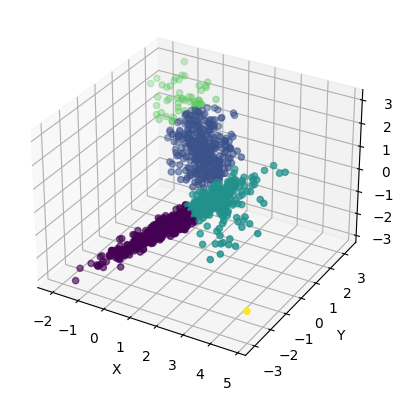

0.42814183582457427
0.5812581236325399
973.8132013358417


In [17]:
# Birch with 5 clusters
labels = clustering(X, 'birch', {'k': 5})
# print(labels)
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

#### DBSCAN

[ 2  3  0  1  2 -1  0 -1  0  2  0  2  0  0  0 -1  2  2  0  0  2  2  0  0
  0  2 -1  0  2  2  0 -1  0  2  0  0  0  0  1  0  0  0 -1  2 -1  0  0  0
  2  2  0  0  0  0  0  0  0  2  2  0  0  0  0 -1  2 -1  0  0  0 -1 -1  0
 -1  0  0 -1  2  2 -1  0 -1 -1 -1  2  0  2  0  0  0  0  2  0  3  0  0  0
  0 -1  1  2  2  0 -1 -1  2 -1  2  0  2  0  0  2  0 -1 -1  0  3  0  2  0
 -1  0 -1 -1 -1  1  0  0 -1  0 -1 -1  0  0  0  0  0  0  2  2 -1  0  2  0
  0 -1  1  0  0  2 -1  0  1 -1  0  0  0  0  0  2 -1  0  1  0 -1 -1  0  0
  2  0  0  0  0  0  2  0  0 -1  0  0  0  3  0  0  0  0  3  0 -1 -1  0  2
 -1  0  0  0  0  2  0 -1  2 -1 -1  0  0  2  0 -1  2  0  0  2 -1  0  0  2
  2 -1  0  0  2  0  2  0  0  0  0  0  0  2  0  2  0  2 -1 -1  2  2  0  0
  2  3  0  0 -1  0  0 -1  2 -1 -1  3 -1  1  0  0  0  3 -1 -1  0  0  2  0
 -1  0  0  0  2  0  0  0  0  0  0  0  2  2  0 -1  0  0  1  0  2  2 -1  0
  2  0  0  0  0  0  2  0  0  0  3  0  0  0 -1  0  0  0  0  0 -1  2  0 -1
  0  0  0  0  0  0 -1  0  0  2  0  0  1  0  2  0  0

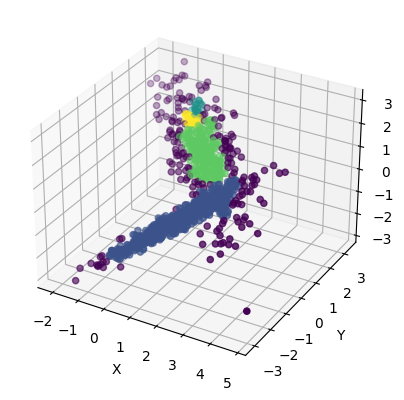

0.21074016240319537
3.689089576394778
198.07894021213357


In [87]:
# dbscan 

#labels = clustering(X, 'dbscan', {'eps': 0.15, 'min_samples': 10})
labels = clustering(X, 'dbscan', {'eps': 0.2, 'min_samples': 10})
#labels = clustering(X, 'dbscan', {'eps': 0.2, 'min_samples': 20}) # variamos el número minimo de puntos para que sea considerado un cluster
#labels = clustering(X, 'dbscan', {'eps': 0.25, 'min_samples': 20})
#labels = clustering(X, 'dbscan', {'eps': 0.6, 'min_samples': 100})
#print(labels)
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

#### K-Means

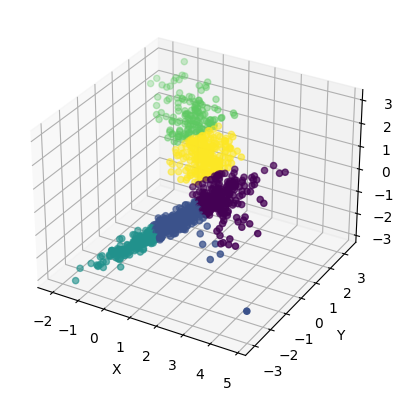

0.4346168081431781
0.7226918478915739
1665.9736682853945


In [19]:
# kmeans with 5 clusters
labels = clustering(X, 'kmeans', {'k': 5})
# print(labels)
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

#### Mini-Batch K-Means

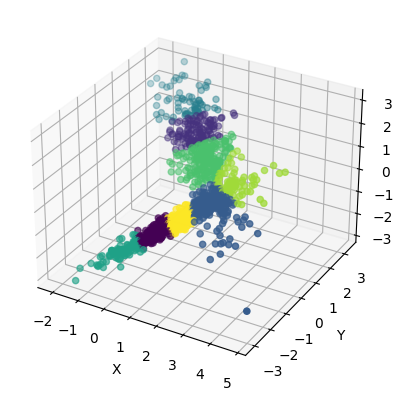

0.35719976604572423
0.8350862351640075
1483.6903032322748


In [20]:
# Mini-batch kmeans with 15 clusters
labels = clustering(X, 'mini_batch_kmeans', {'k': 8})
# print(labels)
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

#### Mean Shift

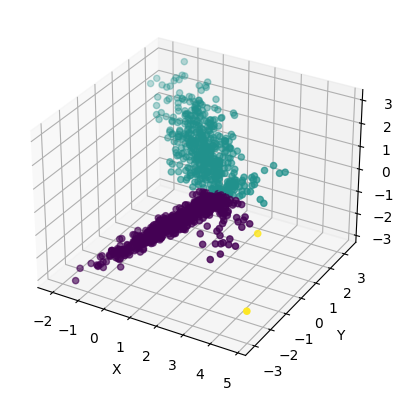

0.47573327573975754
0.7596785363212645
609.1610143476274


In [21]:
# Mean Shift with quantile=0.2 and n_samples=500
labels = clustering(X, 'mean_shift', {'quantile': 0.2, 'n_samples': 500})
# print(labels)
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

#### OPTICS

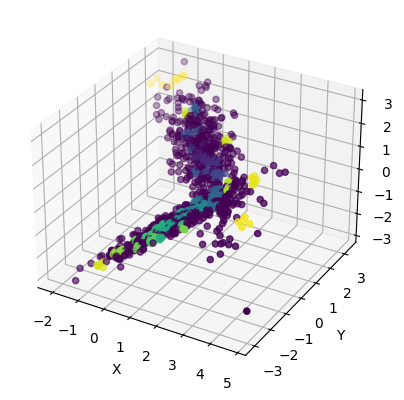

-0.2316755197456546
1.4601777073889028
11.08064913841206


In [22]:
# optics
labels = clustering(X, 'optics', {'eps': 0.75, 'min_samples': 5})
#print(labels)
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

#### Spectral Clustering

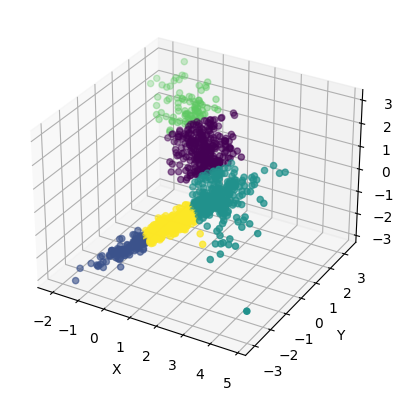

0.4323841273962166
0.6900973404181383
1568.9088989292004


In [23]:
# Spectral Clustering with 5 clusters
labels = clustering(X, 'spectral_clustering', {'k': 5})
# print(labels)
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

#### Mixture of Gaussians

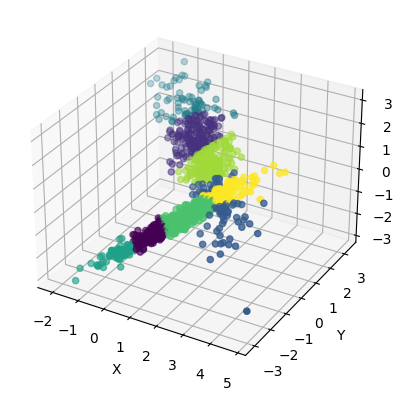

0.35546432564559294
1.1006364940812576
1308.3113121789588


In [24]:
# Mixture of Gaussians with 8 clusters
labels = clustering(X, 'mixture_of_gaussians', {'k': 8})
# print(labels)
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

#### Partition around medoids (PAM)

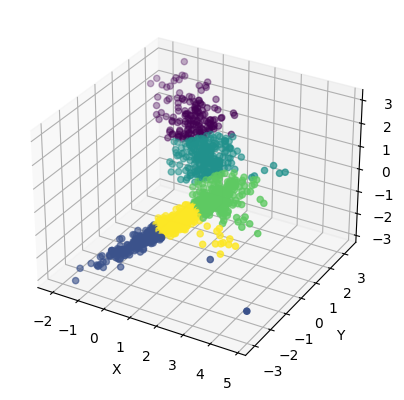

0.41674989544754615
0.7502399525851624
1537.8805267172256


In [25]:
# Partition Around Medoids with 5 clusters
labels = clustering(X, 'partition_around_medoids', {'k': 5})
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

#### UPGMA

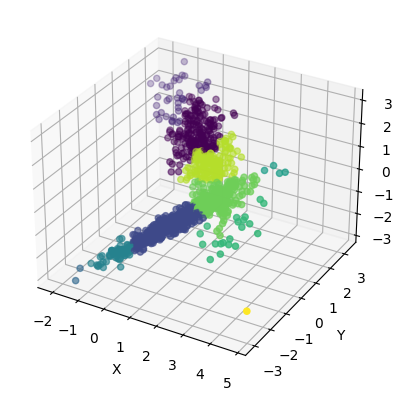

0.35616050967771296
0.653992465723906
864.436905353329


In [28]:
# UPGMA with 10
labels = clustering(X, 'upgma', {'k': 10})
#print(labels)
visualize_labelled_dataset(X, labels)

# Silhouette score
print(get_quality_metric(X, labels, 'silhouette'))
# Davies-Bouldin score
print(get_quality_metric(X, labels, 'davies_bouldin'))
# Calinski-Harabasz score
print(get_quality_metric(X, labels, 'calinski_harabasz'))

### 9. Optimal algorithm hyperparameters <div id = 'id9'></div>

In this section we will define a function that will be used to obtain which is the best algorithm and its optimal hyperparameters for the dataset that we are using, according to a given quality metric. This function receives as parameters the dataset and the quality metric to use, and tries all the previously defined algorithms with different hyperparameters. It returns the best algorithm and its optimal hyperparameters, according to the specified quality metric.

In [67]:
def algorithms_hyperparameters():
    algorithms = ['birch', 'dbscan','kmeans', 'mini_batch_kmeans', 'mean_shift', 'optics', 
                  'spectral_clustering', 'mixture_of_gaussians', 'partition_around_medoids', 'upgma']

    diccionario = {}
    for valor in algorithms:
        if valor in ['dbscan', 'optics']:
            lista_valores = []
            for _ in range(20):
                valor_1 = round(random.uniform(0, 1), 2)
                valor_2 = random.randint(5, 100)
                lista_valores.append([valor_1, valor_2])
            diccionario[valor] = lista_valores
        elif valor == 'mean_shift':
            lista_valores = []
            for _ in range(20):
                valor_1 = round(random.uniform(0, 1), 2)
                valor_2 = random.randint(5, 1000)
                lista_valores.append([valor_1, valor_2])
            diccionario[valor] = lista_valores
        else:
            lista_valores = list(range(2, 11))
            diccionario[valor] = lista_valores
    
    return diccionario


In [117]:
#Create a method that for each algorithm  returns the name of the algorithm and the hyperparameters that best fit the data
def get_best_hyperparameters(data, metric):
    dicc = algorithms_hyperparameters()
    print(dicc)
    algorithms = ['birch', 'dbscan','kmeans', 'mini_batch_kmeans', 'mean_shift', 'optics', 
                  'spectral_clustering', 'mixture_of_gaussians', 'partition_around_medoids', 'upgma']
    
    soluciones = {}
    for alg in algorithms:
        solucion=[]
        for hiper in dicc[alg]:
            if alg in ['dbscan', 'optics']:
                labels = clustering(data, alg, {'eps': hiper[0], 'min_samples': hiper[1]})
                hiperUsed = [alg, hiper[0], hiper[1]]
            elif alg == 'mean_shift':
                labels = clustering(data, alg, {'quantile': hiper[0], 'n_samples': hiper[1]})
                hiperUsed = [alg, hiper[0], hiper[1]]
            else:
                labels = clustering(data, alg, {'k': hiper})
                hiperUsed = [alg, hiper]
                
            if np.all(labels != -1):
                solucion.append([hiperUsed, get_quality_metric(data, labels, metric)])
                print(hiperUsed, get_quality_metric(data, labels, metric))
        
        if metric == 'silhouette' and solucion != []:
            soluciones[alg] = max(solucion, key=lambda x: x[1])
            print('Solucion: ',soluciones[alg])
        elif metric == 'davies_bouldin' and solucion != []:
            soluciones[alg] = min(solucion, key=lambda x: x[1])
            print('Solucion: ',soluciones[alg])
        elif metric == 'calinski_harabasz' and solucion != []:
            soluciones[alg] = max(solucion, key=lambda x: x[1])
            print('Solucion: ',soluciones[alg])
        elif metric !='silhouette' or metric != 'davies_bouldin' or metric != 'calinski_harabasz':
            print('Metric not valid')
        else:
            print()

    return soluciones
    


In [118]:
#get_best_hyperparameters(X, 'silhouette')
get_best_hyperparameters(X, 'davies_bouldin')
#get_best_hyperparameters(X, 'calinski_harabasz')

{'birch': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'dbscan': [[0.88, 62], [0.84, 23], [0.83, 48], [0.35, 96], [0.35, 46], [0.98, 55], [0.38, 63], [0.17, 21], [0.73, 52], [0.68, 37], [0.72, 38], [0.99, 59], [0.21, 89], [0.84, 62], [0.95, 70], [0.86, 43], [0.86, 98], [0.14, 83], [0.29, 8], [0.81, 7]], 'kmeans': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'mini_batch_kmeans': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'mean_shift': [[0.6, 441], [0.82, 993], [0.46, 623], [0.58, 422], [0.25, 578], [0.49, 601], [0.64, 718], [0.53, 211], [0.93, 474], [0.06, 436], [0.89, 52], [0.53, 649], [0.78, 209], [0.64, 367], [0.52, 457], [0.41, 763], [0.23, 773], [0.53, 154], [0.2, 772], [0.84, 100]], 'optics': [[0.93, 72], [0.73, 33], [0.55, 73], [0.96, 34], [0.54, 32], [0.73, 83], [0.3, 45], [0.9, 21], [0.01, 48], [0.31, 66], [0.59, 59], [0.26, 37], [0.43, 93], [0.06, 55], [0.79, 27], [0.71, 46], [0.55, 68], [0.26, 27], [0.52, 99], [0.54, 23]], 'spectral_clustering': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'mixture_of_gaussians': [2, 3, 4, 5, 6, 7, 

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)